In [90]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, count, explode

from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.clustering import KMeans

from pyspark.ml import Pipeline

import os
import pandas as pd
import geopandas
import matplotlib.pyplot as plt


In [91]:
spark = (
    SparkSession
    .builder
    .appName('Cluster Analysis II')
    .getOrCreate()
)

In [92]:
base_path = os.getcwd()

project_path = ('/').join(base_path.split('/')[0:-3]) 

users_input_path = os.path.join(project_path, 'data/users')

In [93]:
driver = 'org.postgresql.Driver'
url = 'jdbc:postgresql://localhost/postgres'
table = 'public.locations'
user = 'postgres'
password = 'postgres'


locations = (
    spark
    .read
    .format('jdbc')
    .option("driver", driver)
    .option('url', url)
    .option('dbtable', table)
    .option('user', user)
    .option('password', password)
    .load()
)

In [94]:
usersDF = (
    spark
    .read
    .option('path', users_input_path)
    .load()
)

In [95]:
locations.show()

+--------------------+--------------------+--------------------+
|                name|            latitude|           longitude|
+--------------------+--------------------+--------------------+
|           Bangalore|12.97911980000000...|77.59129970000000...|
|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
| Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
|                Utah|39.42251920000000...|-111.714358400000...|
|  Caracas, Venezuela|10.50609800000000...|-66.9146017000000...|
|Vancouver, Britis...|49.26087240000000...|-123.113952900000...|
|Brisbane, QLD, Au...|-27.4689682000000...|153.0234991000000...|
|           kathmandu|27.70879600000000...|85.32024400000000...|
|     Gainesville, FL|29.65193960000000...|-82.3249961000000...|
|Izmir, İzmir, Turkey|38.41534210000000...|27.14447400000000...|
|       France/Israel|48.70379630000000...|6.169889500000000000|
|Cluj-Napoca, Cluj...|46.76933670000000...|23.59006040000000...|
|      Pleasanton, CA|37.

In [96]:
data_with_coord = (
    usersDF.alias('users')
    .join(locations.alias('locs'), col('users.location') == col('locs.name'))
    .select('user_id', 'location', 'latitude', 'longitude')
).cache()

In [97]:
data_with_coord.show()

+-------+---------+--------------------+--------------------+
|user_id| location|            latitude|           longitude|
+-------+---------+--------------------+--------------------+
| 165343|Bangalore|12.97911980000000...|77.59129970000000...|
| 207530|Bangalore|12.97911980000000...|77.59129970000000...|
|  40358|Bangalore|12.97911980000000...|77.59129970000000...|
|  82560|Bangalore|12.97911980000000...|77.59129970000000...|
|  86319|Bangalore|12.97911980000000...|77.59129970000000...|
| 153965|Bangalore|12.97911980000000...|77.59129970000000...|
|  59175|Bangalore|12.97911980000000...|77.59129970000000...|
| 101534|Bangalore|12.97911980000000...|77.59129970000000...|
|   4928|Bangalore|12.97911980000000...|77.59129970000000...|
| 135045|Bangalore|12.97911980000000...|77.59129970000000...|
|  76917|Bangalore|12.97911980000000...|77.59129970000000...|
|  99904|Bangalore|12.97911980000000...|77.59129970000000...|
|  57055|Bangalore|12.97911980000000...|77.59129970000000...|
|  92703

In [98]:
features_array = ['latitude', 'longitude']
assembler = VectorAssembler(inputCols=features_array, outputCol='features')
kmeans = KMeans(featuresCol='features', predictionCol='predictions', k=6, seed=1)
pipeline = Pipeline(stages=[assembler, kmeans])
model = pipeline.fit(data_with_coord)

In [99]:
predictions = model.transform(data_with_coord)

In [100]:
(
    predictions
    .groupBy('predictions')
    .count()
).show()

+-----------+-----+
|predictions|count|
+-----------+-----+
|          1| 1348|
|          3|  629|
|          5| 2594|
|          4|  197|
|          2|  505|
|          0|  682|
+-----------+-----+



In [101]:
(
    predictions
    .select('user_id', 'users.location', *features_array)
    .filter(col('predictions') == 0)
    .orderBy('location')
).show()

+-------+--------------------+--------------------+--------------------+
|user_id|            location|            latitude|           longitude|
+-------+--------------------+--------------------+--------------------+
|  82745|             0.0.0.0|-26.7533702000000...|30.40974745559670...|
| 208101|Addis Abeba, Ethi...|9.000000000000000000|38.75000000000000...|
|  75397|         Addis ababa|9.010793400000000000|38.76125250000000...|
|  63103|Agartala,Tripura,...|23.83123770000000...|91.28238210000000...|
|  78967|    Ahmedabad, India|23.02162380000000...|72.57970680000000...|
|   8334|    Ahmedabad, India|23.02162380000000...|72.57970680000000...|
|  81585|    Ahmedabad, India|23.02162380000000...|72.57970680000000...|
| 194410|    Ahmedabad, India|23.02162380000000...|72.57970680000000...|
| 122081|    Ahmedabad, India|23.02162380000000...|72.57970680000000...|
| 212385|    Ahmedabad, India|23.02162380000000...|72.57970680000000...|
|  36351|    Ahmedabad, India|23.02162380000000...|

In [102]:
(
    predictions
    .select('user_id', 'users.location', *features_array)
    .filter(col('predictions') == 1)
).show()

+-------+--------------------+--------------------+--------------------+
|user_id|            location|            latitude|           longitude|
+-------+--------------------+--------------------+--------------------+
| 129807|  Caracas, Venezuela|10.50609800000000...|-66.9146017000000...|
| 106129|  Caracas, Venezuela|10.50609800000000...|-66.9146017000000...|
|  85616|  Caracas, Venezuela|10.50609800000000...|-66.9146017000000...|
| 160262|  Caracas, Venezuela|10.50609800000000...|-66.9146017000000...|
| 176533|     Gainesville, FL|29.65193960000000...|-82.3249961000000...|
|  52947|     Gainesville, FL|29.65193960000000...|-82.3249961000000...|
|  25789|     Gainesville, FL|29.65193960000000...|-82.3249961000000...|
|  10513|     Gainesville, FL|29.65193960000000...|-82.3249961000000...|
|   6739|     Gainesville, FL|29.65193960000000...|-82.3249961000000...|
|   9574|     Gainesville, FL|29.65193960000000...|-82.3249961000000...|
| 187803|     Gainesville, FL|29.65193960000000...|

In [103]:
(
    predictions
    .select('user_id', 'users.location', *features_array)
    .filter(col('predictions') == 2)
).show()

+-------+-------------------+--------------------+--------------------+
|user_id|           location|            latitude|           longitude|
+-------+-------------------+--------------------+--------------------+
|  76877|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
|   2825|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
|  64861|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
| 186045|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
|  38743|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
|   1965|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
|  36972|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
|  26267|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
| 117627|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
|  85818|Brisbane, Australia|-27.4689682000000...|153.0234991000000...|
|  42502|Brisbane, Australia|-27.4689682000000...|153.0234991000

In [104]:
(
    predictions
    .select('user_id', 'users.location', *features_array)
    .filter(col('predictions') == 3)
).show()

+-------+--------------------+--------------------+--------------------+
|user_id|            location|            latitude|           longitude|
+-------+--------------------+--------------------+--------------------+
| 139934|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
|   5123|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
|  56620|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
| 106205|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
| 139476|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
| 194922|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
|  14376|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
| 193860|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
| 141705|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
|  20199|San Francisco Bay...|37.78849690000000...|-122.355847300000...|
|  50340|San Francisco Bay...|37.78849690000000...|

In [105]:
(
    predictions
    .select('user_id', 'users.location', *features_array)
    .filter(col('predictions') == 4)
).show()

+-------+--------------------+--------------------+--------------------+
|user_id|            location|            latitude|           longitude|
+-------+--------------------+--------------------+--------------------+
| 126760|Osaka Prefecture,...|34.61988130000000...|135.4903570000000...|
| 209673|Osaka Prefecture,...|34.61988130000000...|135.4903570000000...|
| 179543|      대한민국 Seoul|37.56667910000000...|126.9782914000000...|
| 172006|      대한민국 Seoul|37.56667910000000...|126.9782914000000...|
| 113937|      대한민국 Seoul|37.56667910000000...|126.9782914000000...|
| 204934|      대한민국 Seoul|37.56667910000000...|126.9782914000000...|
| 212279|      대한민국 Seoul|37.56667910000000...|126.9782914000000...|
| 127891|      대한민국 Seoul|37.56667910000000...|126.9782914000000...|
| 176696|      대한민국 Seoul|37.56667910000000...|126.9782914000000...|
|  44234|Ulaanbaatar, Mong...|47.94980900000000...|106.9667241938810...|
| 155167|Ulaanbaatar, Mong...|47.94980900000000...|106.9667241938810...|
|  684

In [106]:
(
    predictions
    .select('user_id', 'users.location', *features_array)
    .filter(col('predictions') == 5)
).show()

+-------+--------------------+--------------------+--------------------+
|user_id|            location|            latitude|           longitude|
+-------+--------------------+--------------------+--------------------+
|   6629|Izmir, İzmir, Turkey|38.41534210000000...|27.14447400000000...|
|  35586|       France/Israel|48.70379630000000...|6.169889500000000000|
| 186358|Cluj-Napoca, Cluj...|46.76933670000000...|23.59006040000000...|
| 181141|Cluj-Napoca, Cluj...|46.76933670000000...|23.59006040000000...|
| 117127|Cluj-Napoca, Cluj...|46.76933670000000...|23.59006040000000...|
|  76166|Cluj-Napoca, Cluj...|46.76933670000000...|23.59006040000000...|
| 174662|Cluj-Napoca, Cluj...|46.76933670000000...|23.59006040000000...|
| 108943|Cluj-Napoca, Cluj...|46.76933670000000...|23.59006040000000...|
| 211538|Cluj-Napoca, Cluj...|46.76933670000000...|23.59006040000000...|
| 128909|Cluj-Napoca, Cluj...|46.76933670000000...|23.59006040000000...|
| 172403|Cluj-Napoca, Cluj...|46.76933670000000...|

In [108]:
local_clusters = predictions.select('users.location', *features_array, 'predictions').toPandas()

In [109]:
gdf = geopandas.GeoDataFrame(
    local_clusters, 
    geometry=geopandas.points_from_xy(local_clusters.longitude, local_clusters.latitude)
)

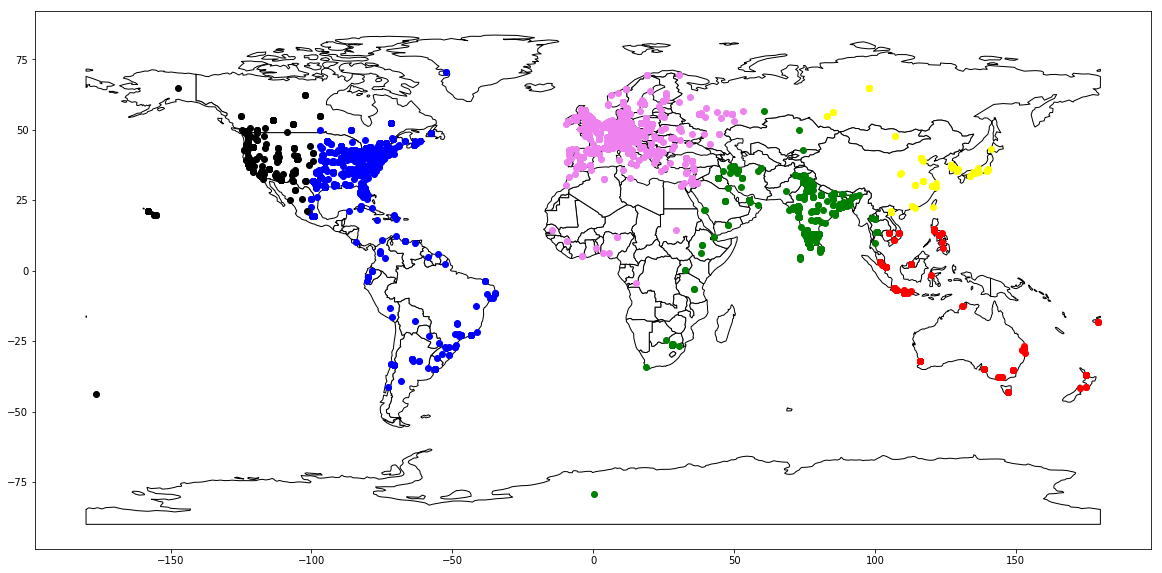

In [110]:
plt.rcParams["figure.figsize"] = (20,10)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')

gdf[gdf['predictions'] == 0].plot(ax=ax, color='green')
gdf[gdf['predictions'] == 1].plot(ax=ax, color='blue')
gdf[gdf['predictions'] == 2].plot(ax=ax, color='red')
gdf[gdf['predictions'] == 3].plot(ax=ax, color='black')
gdf[gdf['predictions'] == 4].plot(ax=ax, color='yellow')
gdf[gdf['predictions'] == 5].plot(ax=ax, color='violet')

plt.show()

In [111]:
# save the result to the database:
(
    predictions
    .select(
        'user_id', 
        col('predictions').alias('cluster_id')
    )
    .write
    .mode('append')
    .format('jdbc')
    .option('url', url)
    .option('dbtable', 'user_clusters')
    .option('user', user)
    .option('password', password)
    .save()
)